In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

---
# Model

In [2]:
def build_model(input_size=100, vocab_size=100, output_size=1):
    inputs = keras.Input((vocab_size,))
    x = layers.Embedding(vocab_size, 32)(inputs)
    
    x = layers.LSTM(64, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(vocab_size, activation="softmax")(x)
    
    return keras.Model(inputs, outputs)

In [3]:
model = build_model()

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 32)           3200      
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
Total params: 38,692
Trainable params: 38,692
Non-trainable params: 0
_________________________________________________________________


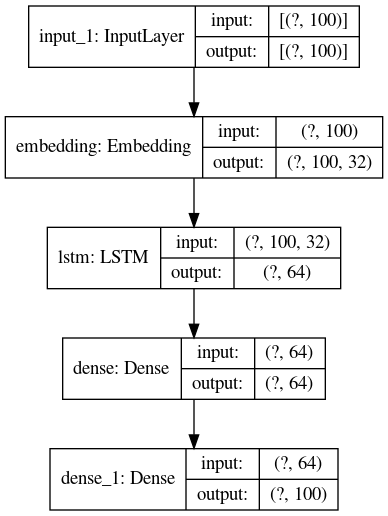

In [5]:
keras.utils.plot_model(model, show_shapes=True)

---
# Data

In [6]:
import tensorflow_datasets as tfds
from tensorflow_datasets.text import imdb

import string
import numpy as np

In [7]:
reviews = imdb.IMDBReviews(config="plain_text")

In [8]:
reviews.download_and_prepare()

In [9]:
datasets = reviews.as_dataset()
rev_train, rev_test = datasets["train"], datasets["test"]

---
## Preprocessing

In [10]:
clean_chars = set(string.printable)

char_to_idx = {c: i for i, c in enumerate(sorted(clean_chars))}
idx_to_char = {i: c for i, c in enumerate(sorted(clean_chars))}

In [11]:
def clean(s):
    return "".join(c for c in s if c in clean_chars)

def make_seq(s, length=100, skip=1):
    return [s[i:i + length] for i in range(0, len(s) - length, skip)]

In [12]:
def seq_generator(dataset, seq_length=100, seq_skip=5):
    for sample in tfds.as_numpy(rev_test):
        text = clean(sample["text"].decode())
        for seq in make_seq(text, seq_length, seq_skip):
            yield seq
            
def sample_generator(dataset, seq_length=100, seq_skip=5, predict_length=1):
    for seq in seq_generator(dataset, seq_length + predict_length, seq_skip):
        yield seq[:seq_length], seq[seq_length:]
        
def sample_idx_generator(dataset, c2i, seq_length=100, seq_skip=5, predict_length=1):
    for text, label in sample_generator(dataset, seq_length, seq_skip, predict_length):
        yield [c2i[c] for c in text], [c2i[c] for c in label]

def batch_generator(dataset, c2i, batch_size=32, seq_length=100, seq_skip=5, predict_length=1):
    num_classes = max(c2i.values()) + 1
    
    batch_x = []
    batch_y = []
    i = 0
    for text, label in sample_idx_generator(rev_train, char_to_idx, seq_length, seq_skip, predict_length):
        if i < batch_size:
            batch_x.append(text)
            batch_y.append(keras.utils.to_categorical(label[0], num_classes)) #todo: remove [0] and make model work with many outputs
            i += 1
        else:
            yield np.array(batch_x), np.array(batch_y)
            batch_x = []
            batch_y = []
            i = 0
        

In [110]:
for i, seq in enumerate(batch_generator(rev_train, char_to_idx)):
    if i > 100:
        break
        
    print(i, seq[0], seq[0].shape, seq[1], seq[1].shape, sep="\n")

0
[[46 12 91 ... 89 77 70]
 [92 70 89 ... 82 70 73]
 [74 73  5 ... 89 77 78]
 ...
 [70 94 12 ... 38 80 80]
 [78 83 72 ... 70  5 70]
 [73 78 71 ...  5 88 84]]
(32, 100)
[[[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]]
(32, 1, 100)
1
[[84 87 82 ... 77 74 88]
 [72 74 17 ... 85 84 85]
 [71 88 84 ... 70 87  5]
 ...
 [80  5 78 ... 80 78 83]
 [73 74 75 ... 84 75  5]
 [78 89 74 ... 87 87 84]]
(32, 100)
[[[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]]
(32, 1, 100)
2
[[ 5 89 70 ... 17  5 77]
 [83 89 74 ... 88  5 73]
 [78 12 91 ... 83 76  5]
 ...
 [73  5 70 ... 84 90 81]
 [84  5 78 ... 76 84  5]
 [73 87 70 ... 87  5 70]]
(32, 100)
[[[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0

---
# Training

In [13]:
data_gen = batch_generator(rev_train, char_to_idx, )

In [14]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [53]:
history = model.fit_generator(data_gen, steps_per_epoch=100, epochs=5)

Epoch 1/5
100/100 [==============================] - 153s 2s/step - loss: 3.1382 - accuracy: 0.1781
Epoch 2/5
100/100 [==============================] - 157s 2s/step - loss: 3.1556 - accuracy: 0.1697
Epoch 3/5
100/100 [==============================] - 149s 1s/step - loss: 3.1273 - accuracy: 0.1725
Epoch 4/5
100/100 [==============================] - 149s 1s/step - loss: 3.1888 - accuracy: 0.1637
Epoch 5/5
100/100 [==============================] - 149s 1s/step - loss: 3.1554 - accuracy: 0.1781


---
# Test

In [51]:
def pad(s, length, char=" "):
    if len(s) >= length:
        return s
    
    return char * (length - len(s)) + s

def to_seq(s):
    return [char_to_idx[c] for c in pad("hello", 100)]

def predict_char(model, input_str):
    seq = to_seq(pad(input_str, model.input_shape[-1]))
    return idx_to_char[model.predict([seq]).argmax()]

In [56]:
predict_char(model, "hello")

' '

In [59]:
model.predict(np.random.randint(100, size=(1, 100))).argsort()

array([[ 2, 96, 97, 68, 37, 67, 54, 64,  1,  4, 11,  3, 98, 16, 65,  0,
        27, 66,  9, 99, 34, 61, 24, 10, 25, 26, 15, 63, 69,  8, 30, 29,
        23, 62, 48, 31, 32, 58, 28, 21, 59, 86, 95, 22, 50, 36,  6, 44,
        42, 53, 41, 51, 79, 43, 52, 49, 55, 60, 93, 47, 14, 39, 56, 13,
        45, 40, 46, 57, 35,  7, 20, 33, 38, 18, 12, 19, 80, 91, 17, 71,
        85, 75, 82, 94, 76, 92, 90, 72, 73, 81, 77, 87, 88, 78, 84, 83,
        70, 89, 74,  5]])